# Start

In [27]:
import pandas as pd
import numpy as np
from datetime import datetime

In [28]:
purchase_data = pd.read_excel("./Analyst_dataset.xlsx", sheet_name='Purchase Exit Survey Data')
airings_data = pd.read_excel("./Analyst_dataset.xlsx", sheet_name='Airings')

# The first row of Lookup table says "Lookup table for survey response field to airings network ticker symbol."  Assuming the first row always says that, we can drop it.
lookup_data = pd.read_excel("./Analyst_dataset.xlsx", sheet_name='Lookup', skiprows=1)

# Preprocessing

In [29]:
# Lookup data is meant to facilitate a join between the purchases data and the spend/lift data, but lookup data has a row will all null values, which doesn't help the join in any way.  I'll drop that row.
lookup_data = lookup_data.dropna(how='all')

# The Exit Survey column and Exit Survey.1 column are identical, so we can drop the duplicated column.
lookup_data.drop(labels='Exit Survey.1', axis=1, inplace=True)

In [30]:
# In order to make sure the joins happen correctly, we need to ensure that the strings we're joining on actually match.

# The purchase data table is pretty messy, but if we assume the second column always contains the names of the networks, we can use .iloc to grab them and ensure they're lowercase 

lookup_data['Exit Survey'] = lookup_data['Exit Survey'].str.lower()
lookup_data['Airings'] = lookup_data['Airings'].str.upper()
airings_data['Network'] = airings_data['Network'].str.upper()
purchase_data.iloc[:, 1] = purchase_data.iloc[:, 1].str.lower()

# Transposing Purchase Exit Survey Data - Converting dates from columns to rows in Purchase Exit Survey Data

The purchases table is extremely messy and would be easier to work with if the rows were dates and the columns were the networks.  If we assume that the first row will always have the year, the third row will always have month names, and the fourth row will always have the day numbers, I can programmatically concatenate all the necessary date information in the form "Year-Month-Day", then use them for the rows.

In [31]:
current_year = purchase_data.iloc[0,:].dropna()
current_year = int(current_year)
current_year

2017

In [32]:
months = []
for month in purchase_data.iloc[2,2:].dropna():
    months.append(month)
months

['September', 'October']

In [33]:
# Grab the row of day numbers and cast as integers
day_nums = np.array(purchase_data.iloc[3,2:], dtype=int)

parsed_dates = []
current_month = months[0]
i = 0

# Walk through the list of day_nums.  

# If current_day_num > next_day_num, that indicates a change in month (ex: If current_day = Sept-30 and next_day = Oct-1, b/c 30 > 1).  When this happens, we concatenate the current_day, then increase i by 1 to set the current_month to the next month for furture concatenation.  

# If current_day_num < next_day_num, that indicates both days are in the same month (ex: If current_day = Sept-5 and next_day = Sept-6, b/c 5 < 6), so we concatenate like normal.

# The try block handles the exception when you get to the last day in day_nums.  Since there are no more days in the list, we get an error when we try to index into the list one day into the future.
for count, current_day_num in enumerate(day_nums, start=1):
    try:
        next_day_num = day_nums[count]
    except:
        pass
    if current_day_num > next_day_num:
        current_date = str(current_year) + '-' + current_month + '-' + str(current_day_num)
        current_date = datetime.strptime(current_date, '%Y-%B-%d').date()
        i += 1
        current_month = months[i]
        parsed_dates.append(current_date)
    else:
        current_date = str(current_year) + '-' + current_month + '-' + str(current_day_num)
        current_date = datetime.strptime(current_date, '%Y-%B-%d').date()
        parsed_dates.append(current_date)

# Now that all the dates have been parsed, we replace the unparsed dates with the parsed ones, then transpose the table.  We now have rows that correspond to dates and columns that correspond to networks
purchase_data.iloc[3,2:] = parsed_dates
purchase_data_transpose = purchase_data.iloc[3:,:].transpose()

## Some Cleanup

In [34]:
# Set the column of dates as the index and rename the axis appropriately
#purchase_data_transpose.index = purchase_data_transpose.iloc[:, 0]
purchase_data_transpose.set_index(3, inplace=True)
purchase_data_transpose.rename_axis('date', inplace=True)

# Drop first row, which doesn't contain anything useful
purchase_data_transpose = purchase_data_transpose.iloc[1:]

# Replace column names with the row of network names and then drop that row
purchase_data_transpose.columns = purchase_data_transpose.iloc[0]
purchase_data_transpose = purchase_data_transpose.drop(labels='source')

# Rename column axis as upper-case "Source" to match original table
purchase_data_transpose.rename_axis('Source', axis='columns', inplace=True)

# Convert index of dates to datetime objects
purchase_data_transpose.index = pd.to_datetime(purchase_data_transpose.index)

In [35]:
# purchase_data_transpose.shape

In [36]:
# purchase_data_transpose.head()

## Done

# Metrics by Network

## Purchases by Network

In [37]:
purchases_by_network = purchase_data_transpose.sum(axis=0)
purchases_by_network = purchases_by_network.to_frame()
purchases_by_network = purchases_by_network.rename(columns={0:'Purchases'})

In [38]:
# purchases_by_network.shape

In [39]:
# purchases_by_network.head()

## Spend and Lift by Network

In [40]:
spend_and_lift_by_network = airings_data.groupby('Network')[['Spend', 'Lift']].agg('sum')

In [41]:
# spend_and_lift_by_network.shape

In [42]:
# spend_and_lift_by_network.head()

## Joins

### Joining Purchases by Network to Lookup Data

In [43]:
purchases_by_network_w_lookup = lookup_data.merge(right=purchases_by_network, left_on='Exit Survey', right_on='Source', how='left')
purchases_by_network_w_lookup.set_index('Exit Survey', inplace=True)

In [44]:
# purchases_by_network_w_lookup.shape

In [45]:
# purchases_by_network_w_lookup.head()

### Joining Purchases/Lookup by Network to Spend and Lift

In [46]:
purchases_spend_lift_by_network = purchases_by_network_w_lookup.merge(right=spend_and_lift_by_network, left_on='Airings', right_index=True, how='left')

In [47]:
# purchases_spend_lift_by_network.shape

In [48]:
# purchases_spend_lift_by_network.head()

## Computing Metrics by Network

In [49]:
purchases_spend_lift_by_network['Conversion Rate (%)'] = purchases_spend_lift_by_network['Purchases'] / purchases_spend_lift_by_network['Lift'] * 100

purchases_spend_lift_by_network['Cost Per Acquisition'] = purchases_spend_lift_by_network['Spend'] / purchases_spend_lift_by_network['Purchases']

purchases_spend_lift_by_network['Cost Per Visitor'] = purchases_spend_lift_by_network['Spend'] / purchases_spend_lift_by_network['Lift']

purchases_spend_lift_by_network['Percent of Purchases'] = purchases_spend_lift_by_network['Purchases'] / sum(purchases_spend_lift_by_network['Purchases'].fillna(0)) * 100

purchases_spend_lift_by_network['Percent of Spend'] = purchases_spend_lift_by_network['Spend'] / sum(purchases_spend_lift_by_network['Spend'].fillna(0)) * 100

purchases_spend_lift_by_network['Percent Pur > Percent Spend'] = purchases_spend_lift_by_network['Percent of Purchases'] > purchases_spend_lift_by_network['Percent of Spend']

In [50]:
# purchases_spend_lift_by_network

In [51]:
# purchases_spend_lift_by_network.shape

## Output results to CSV file

In [52]:
current_year_and_months = str(current_year) + '_' + '_'.join(str(month) for month in months)

purchases_spend_lift_by_network.to_csv(F"./cleaned_output/purchases_spend_lift_by_network_{current_year_and_months}.csv")

## Done

# Metrics by Network and Month

## Purchases by Network and Month

In [53]:
# GroupBy month to find purchases per month for each network
purchase_data_by_month = purchase_data_transpose.groupby(pd.Grouper(freq='M')).agg('sum')

In [54]:
# purchase_data_by_month

In [55]:
# Transpose so that the name of network becomes the rows and purchases per month become columns
purchase_data_by_month = purchase_data_by_month.transpose()

# Stack so that the index of each row corresponds to a network for a given month and row values are the number of purchases for that network in that month
purchase_data_by_month = purchase_data_by_month.stack().to_frame()

# Rename purchases column
purchase_data_by_month.rename(columns={0:'Purchases'}, inplace=True)

# Reset_index to set up for merging tables.  It will be easier to merge by column that by index in future steps
purchase_data_by_month = purchase_data_by_month.reset_index()

In [56]:
# purchase_data_by_month.head()

In [57]:
# purchase_data_by_month.shape

## Spend and Lift by Network and Month

In [58]:
spend_lift_by_network_month = airings_data.groupby(['Network', pd.Grouper(key='Date/Time ET', freq='M')])[['Spend', 'Lift']].agg('sum')

In [59]:
# spend_lift_by_network_month.head()

## Joins

### Joining Purchases by Network and Month to Lookup Data

In [60]:
purchases_by_month_with_lookup = lookup_data.merge(right=purchase_data_by_month, left_on='Exit Survey', right_on='Source', how='left').set_index(['Exit Survey', 'date'])

In [61]:
# purchases_by_month_with_lookup.head()

In [62]:
# print(purchases_by_month_with_lookup.head().to_string())

In [63]:
# purchases_by_month_with_lookup.shape

### Joining Purchases/Lookup by Network and Month to Spend and Lift

In [64]:
purchases_spend_lift_by_network_and_month = purchases_by_month_with_lookup.reset_index().merge(right=spend_lift_by_network_month.reset_index(), left_on=['Airings', 'date'], right_on=['Network', 'Date/Time ET'], how='left')

In [65]:
# purchases_spend_lift_by_network_and_month.head()

In [66]:
# purchases_spend_lift_by_network_and_month.shape

In [67]:
purchases_spend_lift_by_network_and_month = purchases_spend_lift_by_network_and_month.set_index(['Exit Survey', 'date']).drop(labels=['Airings', 'Network', 'Date/Time ET', 'Source'], axis=1)

In [68]:
# purchases_spend_lift_by_network_and_month.head()

In [69]:
# purchases_spend_lift_by_network_and_month.shape

In [70]:
# print(purchases_spend_lift_by_network_and_month.head().to_string())

## Computing Metrics by Network and Month

In [71]:
purchases_spend_lift_by_network_and_month['Conversion Rate (%)'] = purchases_spend_lift_by_network_and_month['Purchases'] / purchases_spend_lift_by_network_and_month['Lift'] * 100

purchases_spend_lift_by_network_and_month['Cost Per Acquisition'] = purchases_spend_lift_by_network_and_month['Spend'] / purchases_spend_lift_by_network_and_month['Purchases']

purchases_spend_lift_by_network_and_month['Cost Per Visitor'] = purchases_spend_lift_by_network_and_month['Spend'] / purchases_spend_lift_by_network_and_month['Lift']

purchases_spend_lift_by_network_and_month['Percent of Purchases'] = purchases_spend_lift_by_network_and_month['Purchases'] / sum(purchases_spend_lift_by_network_and_month['Purchases'].fillna(0)) * 100

purchases_spend_lift_by_network_and_month['Percent of Spend'] = purchases_spend_lift_by_network_and_month['Spend'] / sum(purchases_spend_lift_by_network_and_month['Spend'].fillna(0)) * 100

purchases_spend_lift_by_network_and_month['Percent Pur > Percent Spend'] = purchases_spend_lift_by_network_and_month['Percent of Purchases'] > purchases_spend_lift_by_network_and_month['Percent of Spend']

In [72]:
# purchases_spend_lift_by_network_and_month.head()

In [73]:
# print(purchases_spend_lift_by_network_and_month.head().to_string())

## Output results to CSV file

In [74]:
purchases_spend_lift_by_network_and_month.to_csv(F"./cleaned_output/purchases_spend_lift_by_network_and_month_{current_year_and_months}.csv")

## Done

# Report

## Overall Metrics - Establishing a baseline

In [75]:
total_purchases = sum(purchases_spend_lift_by_network['Purchases'].fillna(0))
total_spend = sum(purchases_spend_lift_by_network['Spend'].fillna(0))
total_lift = sum(purchases_spend_lift_by_network['Lift'].fillna(0))

total_lift

20487.0

### Cost Per Visitor = $ \frac{\text{total spend}}{\text{total lift}}$

In [76]:
cost_per_visitor = total_spend / total_lift
cost_per_visitor = round(cost_per_visitor, 2)
print(F"The overall cost per visitor for the TV campaign is ${cost_per_visitor}")

The overall cost per visitor for the TV campaign is $10.81


### Conversion Rate = $ \frac{\text{total # of purchases}}{\text{total lift}} $

In [77]:
conversion_rate =  total_purchases / total_lift
conversion_rate = round(conversion_rate * 100, 2)
print(F"The overall conversion rate for the TV campaign is {conversion_rate}%")

The overall conversion rate for the TV campaign is 1.15%


### Cost Per Acquisition = $ \frac{\text{total spend}}{\text{total # of purchases}} $

In [78]:
cost_per_acquisition = total_spend / total_purchases
cost_per_acquisition = round(cost_per_acquisition, 2)
print(F"The overall cost per acquisition for the TV campaign is ${cost_per_acquisition}")

The overall cost per acquisition for the TV campaign is $938.29


In [79]:
purchases_spend_lift_by_network.head()

,Airings,Purchases,Spend,Lift,Conversion Rate (%),Cost Per Acquisition,Cost Per Visitor,Percent of Purchases,Percent of Spend,Percent Pur > Percent Spend
Exit Survey,,,,,,,,,,
(blank),NaN,3.0,NaN,NaN,NaN,NaN,NaN,1.271186,NaN,False
aapka_colors,NaN,6.0,NaN,NaN,NaN,NaN,NaN,2.542373,NaN,False
baby_first,BABY,1.0,NaN,NaN,NaN,NaN,NaN,0.423729,NaN,False
bloomberg,BLOM,2.0,4966.72,199.0,1.005025,2483.36,24.958392,0.847458,2.242951,False
cbs_sports,CBSS,1.0,NaN,NaN,NaN,NaN,NaN,0.423729,NaN,False


In [80]:
report_for_client = purchases_spend_lift_by_network.drop(['Airings', 'Percent of Purchases', 'Percent of Spend', 'Percent Pur > Percent Spend'], axis=1).dropna(how='all').fillna(0)

report_for_client.head()

,Purchases,Spend,Lift,Conversion Rate (%),Cost Per Acquisition,Cost Per Visitor
Exit Survey,,,,,,
(blank),3.0,0.00,0.0,0.000000,0.00,0.000000
aapka_colors,6.0,0.00,0.0,0.000000,0.00,0.000000
baby_first,1.0,0.00,0.0,0.000000,0.00,0.000000
bloomberg,2.0,4966.72,199.0,1.005025,2483.36,24.958392
cbs_sports,1.0,0.00,0.0,0.000000,0.00,0.000000


In [81]:
report_for_client = report_for_client.round({"Purchases":0, "Spend":2, "Lift":0, "Conversion Rate":0, "Cost Per Acquisition":2, "Cost Per Visitor":2})

report_for_client[['Purchases', 'Lift']] = report_for_client[['Purchases', 'Lift']].astype(int)

report_for_client.rename_axis('Exit Survey Source', axis =0, inplace=True)

report_for_client = report_for_client.sort_values('Exit Survey Source')

In [82]:
report_for_client.index = report_for_client.index.str.replace('_', ' ').str.title()

In [83]:
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

# #df = pd.DataFrame(np.random.random((10,3)), columns = ("col 1", "col 2", "col 3"))

# #https://stackoverflow.com/questions/32137396/how-do-i-plot-only-a-table-in-matplotlib
# fig, ax = plt.subplots(figsize=(12,4))
# #plt.title('Purchases, Spend, and Lift by Network')
# ax.axis('tight')
# ax.axis('off')
# the_table = ax.table(cellText=report_for_client.values,colLabels=report_for_client.columns,loc='center')

# #https://stackoverflow.com/questions/4042192/reduce-left-and-right-margins-in-matplotlib-plot
# pp = PdfPages("foo.pdf")
# pp.savefig(fig, bbox_inches='tight')
# pp.close()

In [85]:
import pdfkit

f = open('./reports_output/html/report_for_client.html','w')
a = report_for_client.to_html(col_space='100px')
f.write(a)
f.close()

pdfkit.from_file('./reports_output/html/report_for_client.html', './reports_output/pdfs/report_for_client.pdf')

,Purchases,Spend,Lift,Conversion Rate (%),Cost Per Acquisition,Cost Per Visitor
Exit Survey Source,,,,,,
(Blank),3,0.00,0,0.000000,0.00,0.00
Aapka Colors,6,0.00,0,0.000000,0.00,0.00
Baby First,1,0.00,0,0.000000,0.00,0.00
Bloomberg,2,4966.72,199,1.005025,2483.36,24.96
Cbs Sports,1,0.00,0,0.000000,0.00,0.00


## Report sorted by Purchases

In [92]:
report_purchases_sorted = report_for_client.sort_values('Purchases', ascending=False)

In [93]:
f = open('./reports_output/html/report_purchases_sorted.html','w')
a = report_purchases_sorted.to_html(col_space='100px')
f.write(a)
f.close()

pdfkit.from_file('./reports_output/html/report_purchases_sorted.html', './reports_output/pdfs/report_purchases_sorted.pdf')

True

In [94]:
import matplotlib.pyplot as plt

In [95]:
plt.bar(x=report_purchases_sorted.index, height='Purchases')

TypeError: bar() missing 1 required positional argument: 'height'

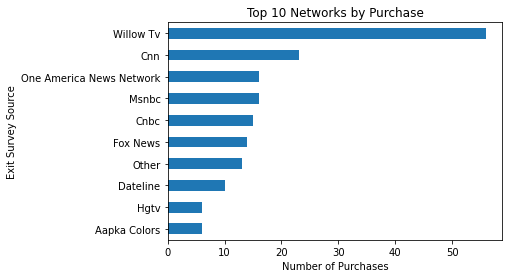

In [115]:
ax = report_purchases_sorted[0:10].plot(kind='barh', y='Purchases', title='Top 10 Networks by Purchase', legend=False)
ax.invert_yaxis()
ax.set_xlabel('Number of Purchases');

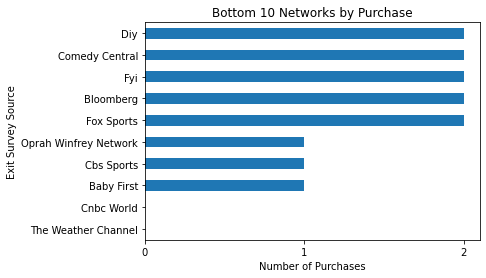

In [118]:
ax = report_purchases_sorted[-10:].plot(kind='barh', y='Purchases', title='Bottom 10 Networks by Purchase', legend=False)
ax.invert_yaxis()
ax.set_xlabel('Number of Purchases')
ax.set_xticks(np.arange(0,3,1));

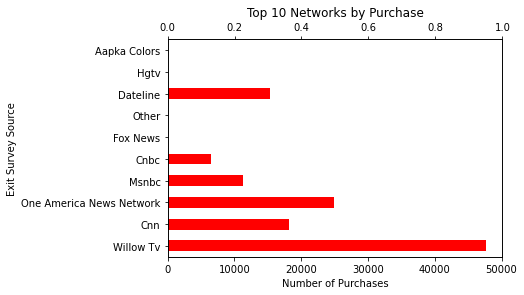

In [127]:
ax = report_purchases_sorted[0:10].plot(kind='barh', y='Purchases', title='Top 10 Networks by Purchase', legend=False, color='blue')
ax.invert_yaxis()
ax.set_xlabel('Number of Purchases')
ax1 = ax.twiny()
report_purchases_sorted[0:10].plot(kind='barh', y='Spend', title='Top 10 Networks by Purchase', legend=False, ax=ax, color='r');

''

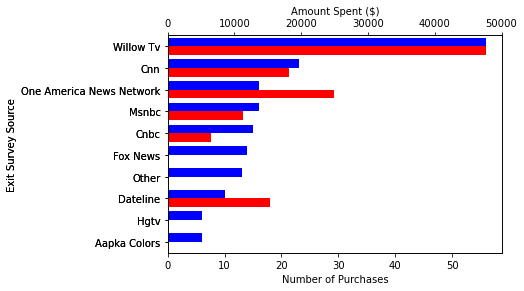

In [161]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('Number of Purchases')


ax2 = ax.twiny()
ax2.set_xlabel('Amount Spent ($)')


report_purchases_sorted['Purchases'][0:10].plot(kind='barh', color='blue', position=1, width=0.4, ax=ax)
report_purchases_sorted['Spend'][0:10].plot(kind='barh', color='red', position=0, width=0.4, ax=ax2)

#ax2.invert_yaxis()
plt.ylim((-0.5, len(report_purchases_sorted[0:10])-0.5))
ax.invert_yaxis()
;

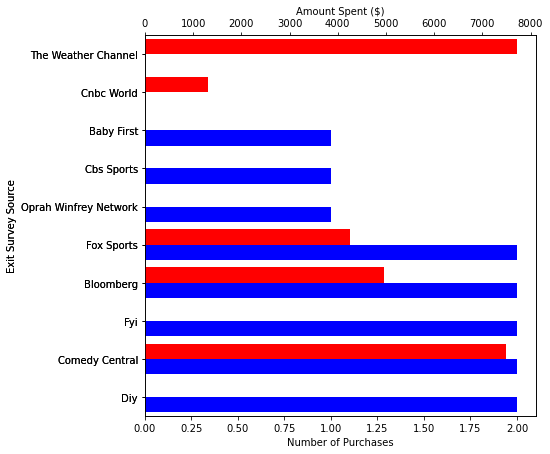

In [157]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_xlabel('Number of Purchases')


ax2 = ax.twiny()
ax2.set_xlabel('Amount Spent ($)')


report_purchases_sorted['Purchases'][-10:].plot(kind='barh', color='blue', position=1, width=0.4, ax=ax)
report_purchases_sorted['Spend'][-10:].plot(kind='barh', color='red', position=0, width=0.4, ax=ax2)
ax.invert_yaxis()
#ax2.invert_yaxis()
plt.ylim((-0.5, len(report_purchases_sorted[0:10])-0.5));

<AxesSubplot:ylabel='Exit Survey Source'>

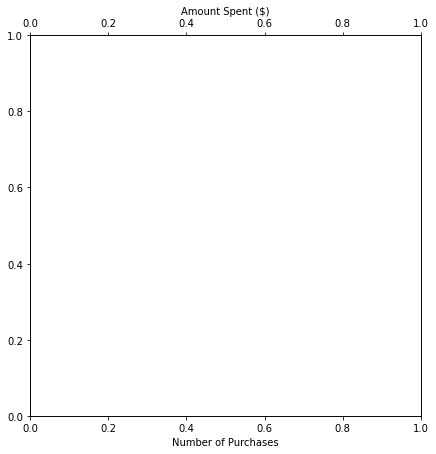

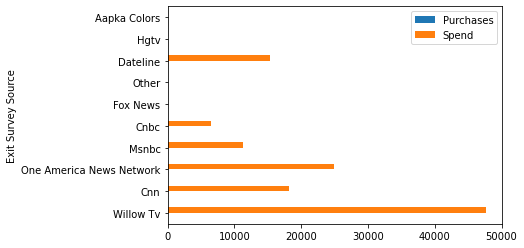

In [159]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_xlabel('Number of Purchases')


ax2 = ax.twiny()
ax2.set_xlabel('Amount Spent ($)')

report_purchases_sorted[['Purchases', 'Spend']][0:10].plot(kind='barh')